In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from copy import deepcopy
from math import prod
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.signal import stft

data0 = np.load("dataset/s03_1.npy")
data1 = np.load("dataset/s03_2.npy")
data2 = np.load("dataset/s03_3.npy")

d0 = np.load("dataset/s03_1.npy").reshape(-1, 4)
d1 = np.load("dataset/s03_2.npy").reshape(-1, 4)
d2 = np.load("dataset/s03_3.npy").reshape(-1, 4)

data_stream = np.concatenate([d0, d1, d2], axis=0)  # shape: (38400, 4)
data_stream = data_stream[:12800]  # pega apenas os primeiros 12800 samples

np.save("dataset/s03_stream.npy", data_stream)
print("Arquivo s03_stream.npy salvo com shape:", data_stream.shape)

data = np.concatenate([data0, data1, data2], axis=0)
print("Shape dos dados combinados:", data.shape)

Arquivo s03_stream.npy salvo com shape: (12800, 4)
Shape dos dados combinados: (24, 1600, 4)


Funções de Filtragem no Dominio do Tempo

In [52]:
# Definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data, padlen=len(data) // 2 )


def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)


def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

Aplicação dos Fitros Temporais nos Dados

In [53]:
data = data.transpose(0,2,1)
print(data.shape)

data_filtered = butter_bandpass(data, 5, 50)
data_filtered = butter_notch(data_filtered, 60)

# data_filtered = data_filtered.transpose(0,2,1)
data_filtered.shape

data = deepcopy(data_filtered)

(24, 4, 1600)


Segmentação dos Dados

In [54]:
step = 103
segment = 256
#data = data_filterded.reshape(60, 2, 20000)
print('', data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=256, noverlap=128)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 14, 256) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 14, 129) - (classes+ensaios, canais, janelas, linhas)


Features

In [55]:
# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2


# funções de extração de características

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def wl(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)

def zc(x):
    real_part = np.real(x)
    sign_changes = np.diff(np.sign(real_part), axis=-1)
    return np.sum(sign_changes != 0, axis=-1)

# Funções do dominio do Tempo 

def log_det(x):
    from math import e
    return e ** (np.sum(np.log10(np.abs(x)), axis=-1) /  np.prod(x.shape))

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def mf(w):
    return (np.sum(PSD(w), axis=-1) / np.sum(PSD(w), axis=-1)) / 2

In [56]:
final_data = list()
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time))
# final_data.append(log_det(chunks_time))
final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(mf(chunks_freq))

final = np.array(final_data)
final.shape

X = final.transpose(1, 3, 2, 0)
vis = final.transpose(1, 3, 2, 0)
print('shape para classificação:', X.shape)

np.save('dataset/teste.npy', X)

data = final.transpose(0, 1, 3, 2)
sh = X.shape
data = data.reshape(sh[0] * sh[1], sh[2] *sh[3] )
print('shape para visualização:', data.shape)
X = data

shape para classificação: (24, 14, 4, 7)
shape para visualização: (336, 28)


Rótulos

In [57]:
y = list()
for i in range(8):
    l = [i] * 14
    y.append(l)
y = y * 3
y = np.array(y).flatten()
print(y, y.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7
 7 7 7] (336,)


Grafico

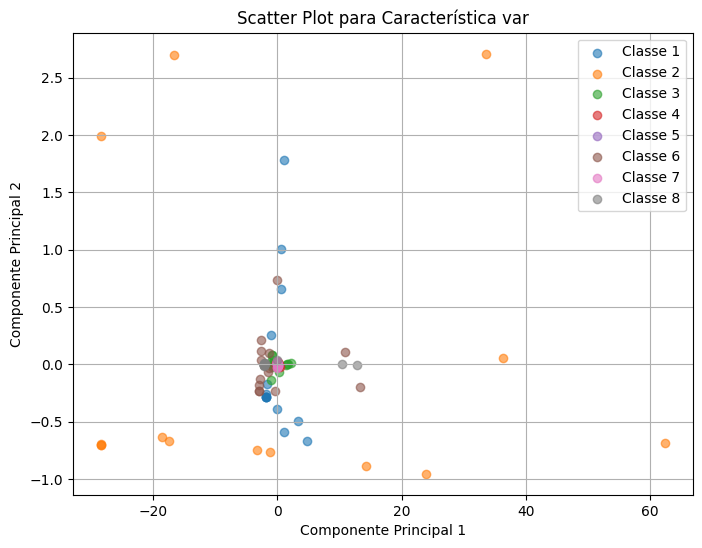

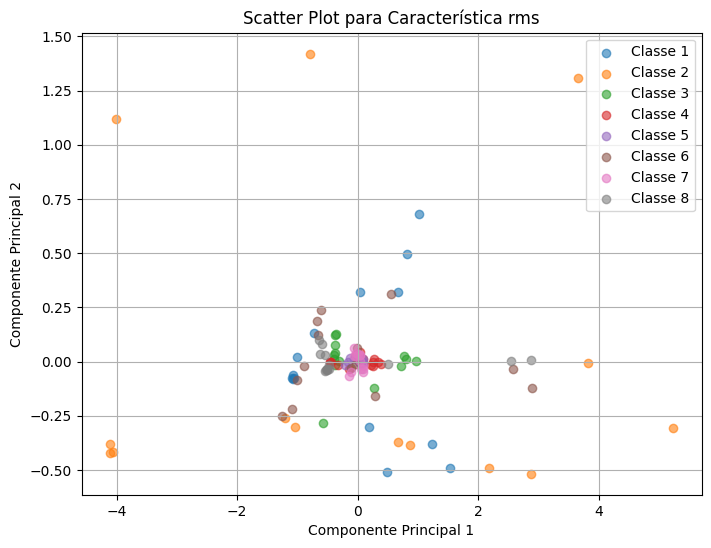

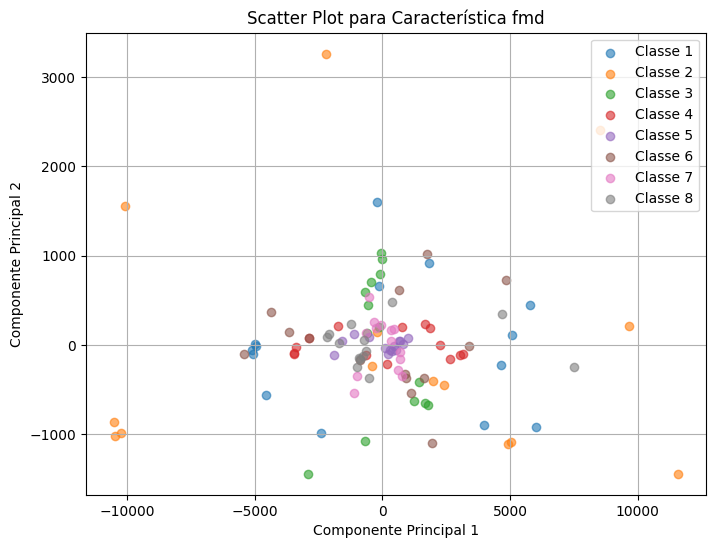

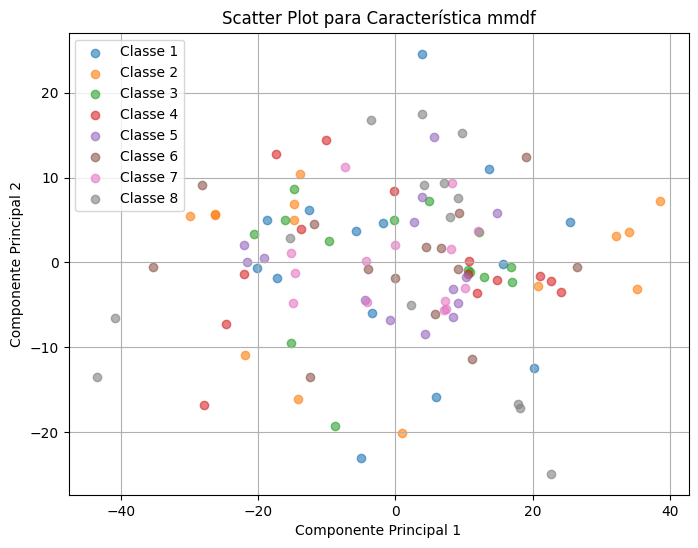

In [58]:
# Initialize PCA with 2 components
pca = PCA(n_components=2)

feature_names = ['var', 'rms', 'fmd', 'mmdf']

# Iterar sobre as 4 características
for feature_idx in range(4):
    plt.figure(figsize=(8, 6))
    for class_idx in range(8):  # Iterar sobre as 8 classes
        # Selecionar os dados da classe e característica atual
        data = vis[class_idx, :, :, feature_idx]
        # Aplicar PCA para reduzir de 4 para 2 dimensões
        data_pca = pca.fit_transform(data.reshape(-1, 4))
        # Scatter plot para a classe atual
        plt.scatter(data_pca[:, 0], data_pca[:, 1], label=f'Classe {class_idx + 1}', alpha=0.6)

    plt.title(f'Scatter Plot para Característica {feature_names[feature_idx]}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.grid(True)
    plt.show()


Grafico 

In [59]:
# import matplotlib.pyplot as plt
# from matplotlib import rcParams

# plt.rcParams["figure.figsize"] = (12, 12)

# features_name = ('var', 'rms', 'log detector', 'fmd', 'mmdf')
# classes = [str(item) for item in list(range(10))]
# plot_features(data, features_name, classes, 0, 1)

Aplicação do Classificador

In [60]:
print(X.shape)
# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
# com embaralhamento sempre ativo (shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

(336, 28)


Classificador SVM

In [61]:
# modelo de classificador com os parâmetros padrões

clf = SVC(kernel='rbf', gamma='scale')

# criando o modelo de classificação com os dados de treino
clf.fit(X_train, y_train)

# aplicando o classificador nos dados de teste
res = clf.predict(X_test)

# obtendo e ajustando os resultados 
tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))

Acurácia: 11.88%


In [62]:
def processar_buffer(buffer, clf):
    # 1. Filtros
    buffer_filt = butter_bandpass(buffer.T, 5, 50)
    buffer_filt = butter_notch(buffer_filt, 60)
    buffer_filt = buffer_filt.T

    # 2. Segmentação
    step = 103
    segment = 256
    n_win = int((buffer_filt.shape[0] - segment) / step) + 1
    ids = np.arange(n_win) * step
    chunks_time = np.array([buffer_filt[k:k+segment].T for k in ids])  # (janelas, canais, segmento)

    _, _, Zxx = stft(buffer_filt.T, fs=200, nperseg=256, noverlap=128)
    chunks_freq = np.swapaxes(Zxx, 1, 2)  # (canais, janelas, freq)
    chunks_freq = chunks_freq.transpose(1, 0, 2)  # (janelas, canais, freq)

    # Funções auxiliares
    def PSD(w): return np.abs(w) ** 2
    def var(x): return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)
    def rms(x): return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))
    def fmd(w): return np.sum(PSD(w), axis=-1) / 2
    def mmdf(w): return np.sum(np.abs(w), axis=-1) / 2
    def mf(w): 
        psd = PSD(w)
        freqs = np.arange(w.shape[-1])
        return np.sum(freqs * psd, axis=-1) / (np.sum(psd, axis=-1) + 1e-10)

    features_list = [
        var(chunks_time),
        rms(chunks_time),
        fmd(chunks_freq),
        mmdf(chunks_freq),
        mf(chunks_freq),
        zc(chunks_time),
        wl(chunks_time)
    ]

    shapes = [f.shape for f in features_list]
    if not all(s == shapes[0] for s in shapes):
        for idx, shape in enumerate(shapes):
            print(f"Feature {idx}: shape = {shape}")
        raise ValueError("Funções de extração retornaram formas diferentes!")

    features = np.stack(features_list, axis=-1)  # (janelas, canais, características)
    features = features.reshape(features.shape[0], -1)  # flatten para SVC
    pred = clf.predict(features)
    return pred



def simular_streaming(caminho_arquivo, clf):
    data_full = np.load(caminho_arquivo)  # shape: (12800, 4)
    buffer_len = 1600
    total_buffers = data_full.shape[0] // buffer_len

    print(f"\nSimulando streaming de {total_buffers} buffers...")
    
    for i in range(total_buffers):
        print(f"\n🔄 Processando buffer {i+1}/{total_buffers}")
        buffer = data_full[i*buffer_len:(i+1)*buffer_len, :]
        predicoes = processar_buffer(buffer, clf)
        print(f"✅ Predições: {predicoes}")


print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))

# Simulação de fluxo em tempo real
simular_streaming("dataset/s03_stream.npy", clf)


Acurácia: 11.88%

Simulando streaming de 8 buffers...

🔄 Processando buffer 1/8
✅ Predições: [3 3 3 3 3 3 3 0 0 0 7 7 0 0]

🔄 Processando buffer 2/8
✅ Predições: [3 3 3 3 0 7 7 7 7 7 7 7 0 0]

🔄 Processando buffer 3/8
✅ Predições: [3 3 0 0 0 0 3 3 3 3 3 3 3 3]

🔄 Processando buffer 4/8
✅ Predições: [3 3 3 3 3 3 3 3 3 3 0 0 0 0]

🔄 Processando buffer 5/8
✅ Predições: [3 3 3 3 3 3 3 3 3 3 3 3 3 3]

🔄 Processando buffer 6/8
✅ Predições: [3 3 3 3 3 0 0 0 0 0 0 7 0 0]

🔄 Processando buffer 7/8
✅ Predições: [3 3 3 3 3 3 3 3 3 3 3 3 3 3]

🔄 Processando buffer 8/8
✅ Predições: [3 3 3 3 3 3 3 3 3 3 3 7 0 0]


## Tarefa Final

Treinar o modelo com um trial e fazer um buffer com os outros trials 